In [1]:
import torch
from torch import nn # neural network
import matplotlib.pyplot as plt
import numpy as np
torch.__version__


'2.5.1+cu124'

## Pytorch workflow

### 1. Data (prepare and load)
### 2. Model (build)
### 3: Fitting the model to data (training)
### 4. Making predictions and evaluating a model (inference)
### 5. Saving and loading a model
### 6. Putting it all together    




## 1. Data (prepare and load) 
* excel spreadsheet
* Images
* Audio, video, DNA, text...
* --> GET DATA INTO NUMERICAL REPRESENTATION
* --> BUILD A MODEL TO LEARN PATTERNS IN DATA


### Linear regression

In [2]:
weight = 0.8
bias = 0.5

start = 0
end = 1 
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]




(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.5000],
         [0.5160],
         [0.5320],
         [0.5480],
         [0.5640],
         [0.5800],
         [0.5960],
         [0.6120],
         [0.6280],
         [0.6440]]))

## Spitting data into training and testing sets

In [3]:
train_split = int(0.8 * len(X))
print(f"Train split: {train_split}")
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)



Train split: 40


(40, 40, 10, 10)

### Data visualisation

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10,7))
    # plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    # plot test data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')
    # plot predictions in red
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
    plt.legend(prop={'size': 14})
    plt.show()



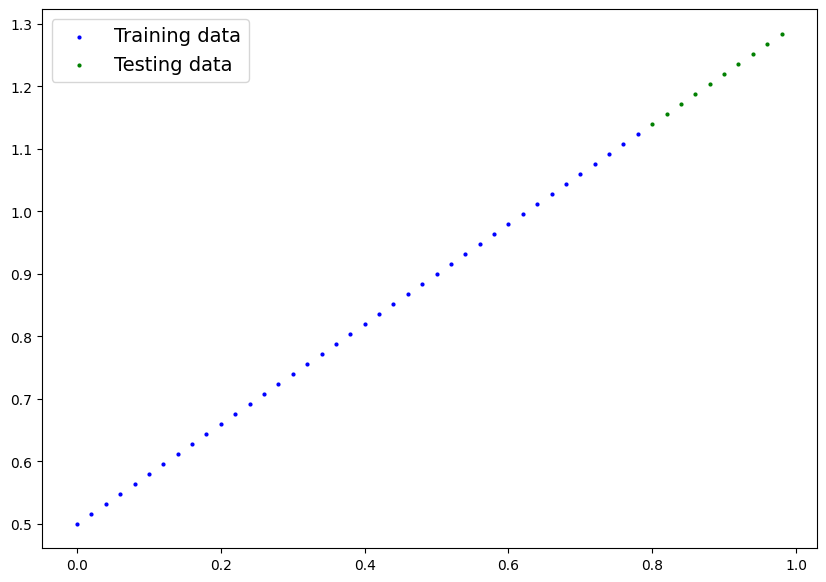

In [5]:
plot_predictions(); 

## Build model
### Linear regression model class

In [6]:
from torch import nn

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, 
                                                requires_grad=True, 
                                                dtype=torch.float),
                                   )
        self.bias = nn.Parameter(torch.randn(1, 
                                            requires_grad=True, 
                                            dtype=torch.float),
                                )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias
    
torch.manual_seed(42)
model_0 = LinearRegressionModel()
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### What the model is doing: 
* Start with random values (weight and bias)
* Look at training data and adjust the random guess (weight and bias) to better represent the data
* We want to improve the model over time
* 2 main methods: Gradient descent and backpropagation

### Pytorch model building essentials
* torch.nn - contains all of the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a Pytorch layer will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should override forward()
* torch.optim - this is where the optimizers in Pytorch are defined
* def forward() - All nn.Module subclasses require you to override forward(), this method defines the computation in the model


### Checking the contents of our Pytorch model

In [7]:
import torch

torch.manual_seed(20)
model_0 = LinearRegressionModel()

print('---> to check model parameters: list(model_0.parameters())')
print(list(model_0.parameters()))

print('---> to check model forward method: model_0.forward(torch.tensor([0.0]))')
print(model_0.forward(torch.tensor([0.0])))

print('---> to check model parameters: list(model_0.parameters())')
print(list(model_0.parameters()))

print('---> to list named parameters: model_0_state_dict')
model_0_state_dict = model_0.state_dict()
print(model_0_state_dict)


---> to check model parameters: list(model_0.parameters())
[Parameter containing:
tensor([-1.2061], requires_grad=True), Parameter containing:
tensor([0.0617], requires_grad=True)]
---> to check model forward method: model_0.forward(torch.tensor([0.0]))
tensor([0.0617], grad_fn=<AddBackward0>)
---> to check model parameters: list(model_0.parameters())
[Parameter containing:
tensor([-1.2061], requires_grad=True), Parameter containing:
tensor([0.0617], requires_grad=True)]
---> to list named parameters: model_0_state_dict
OrderedDict({'weights': tensor([-1.2061]), 'bias': tensor([0.0617])})


### The aim is to get closer to the true values of weight and bias


In [8]:
print(list(model_0.parameters())[0], list(model_0.parameters())[1])
print('---> should be approaching: weight: 0.8, bias: 0.5')


Parameter containing:
tensor([-1.2061], requires_grad=True) Parameter containing:
tensor([0.0617], requires_grad=True)
---> should be approaching: weight: 0.8, bias: 0.5


### Predictions with torch.inference_mode()

In [9]:
with torch.inference_mode():
    y_preds = model_0(X_test)

print('---> to check predictions: y_preds')
print(y_preds)
print('---> to be compared with: y_test')
print(y_test)




---> to check predictions: y_preds
tensor([[-0.9032],
        [-0.9273],
        [-0.9514],
        [-0.9756],
        [-0.9997],
        [-1.0238],
        [-1.0479],
        [-1.0720],
        [-1.0962],
        [-1.1203]])
---> to be compared with: y_test
tensor([[1.1400],
        [1.1560],
        [1.1720],
        [1.1880],
        [1.2040],
        [1.2200],
        [1.2360],
        [1.2520],
        [1.2680],
        [1.2840]])


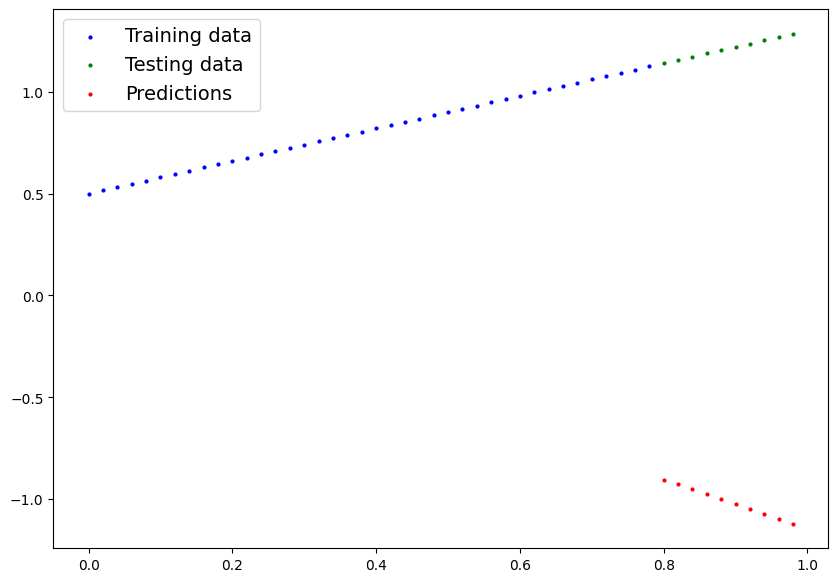

In [10]:
plot_predictions(predictions=y_preds)

## Train model
### The aim is to move from unknown parameters to known parameters, 
### Need to measure how well the model is doing with loss function = cost function = criterion

In [11]:
list(model_0.parameters())


[Parameter containing:
 tensor([-1.2061], requires_grad=True),
 Parameter containing:
 tensor([0.0617], requires_grad=True)]

In [12]:
model_0.state_dict()

OrderedDict([('weights', tensor([-1.2061])), ('bias', tensor([0.0617]))])

### For Pytorch, we need to set up a loss function and optimizer
* Loss function - how wrong the model is
* Optimizer - how the model is updated based on the data it sees and its loss function

### Need to set up: 
* Training loop
* Testing loop



### Set up a loss function

In [13]:
loss_fn = nn.L1Loss() 

### Set up an optimizer
# stochastic gradient descent: a parameter is the value that the model sets itself
optimizer = torch.optim.SGD(params=model_0.parameters(), # stochastic gradient descent
                            lr=0.01) # learning rate




### What we need for a training loop
* Loop through the data
* Forward pass: involves data moving through the model's forward() function = forward propagation
* Calculate the loss = compare forward pass prediction to ground truth labels 
* Optimizer zero grad
* Loss backward = Backpropagation: move backwards through the network to calculate the gradient of each of the parameters of our model with respect to the loss 
* Optimizer step = Gradient descent: used to adjust our model's parameters to try and improve the loss





In [14]:
print(X_train)
print(X_test)


tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800],
        [0.2000],
        [0.2200],
        [0.2400],
        [0.2600],
        [0.2800],
        [0.3000],
        [0.3200],
        [0.3400],
        [0.3600],
        [0.3800],
        [0.4000],
        [0.4200],
        [0.4400],
        [0.4600],
        [0.4800],
        [0.5000],
        [0.5200],
        [0.5400],
        [0.5600],
        [0.5800],
        [0.6000],
        [0.6200],
        [0.6400],
        [0.6600],
        [0.6800],
        [0.7000],
        [0.7200],
        [0.7400],
        [0.7600],
        [0.7800]])
tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])


In [15]:
# Epochs = loops through the data
epochs = 1000
 # lists to track the results
epoch_count = []
loss_values = []
test_loss_values = []

# Loop through the data
for epoch in range(epochs):
    model_0.train() # set the model to training mode
    # 1. Forward pass
    y_pred = model_0(X_train)
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train) # (input, target)
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()
    # 6. Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout / batchnorm)
    with torch.inference_mode(): #turns off gradient tracking 
        test_pred = model_0(X_test) # forward pass
        test_loss = loss_fn(test_pred, y_test)

    # 7. Track metrics
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f"Loss: {loss}")


Loss: 1.220697045326233
Loss: 1.2091758251190186
Loss: 1.1976549625396729
Loss: 1.1861339807510376
Loss: 1.1746128797531128
Loss: 1.163091778755188
Loss: 1.1515707969665527
Loss: 1.140049695968628
Loss: 1.1285288333892822
Loss: 1.117007851600647
Loss: 1.1054866313934326
Loss: 1.0939656496047974
Loss: 1.082444667816162
Loss: 1.0709235668182373
Loss: 1.059402585029602
Loss: 1.0478816032409668
Loss: 1.036360502243042
Loss: 1.0248396396636963
Loss: 1.0133185386657715
Loss: 1.0017975568771362
Loss: 0.9902764558792114
Loss: 0.9787555932998657
Loss: 0.9672344326972961
Loss: 0.9557134509086609
Loss: 0.9441925287246704
Loss: 0.9326713681221008
Loss: 0.9211503863334656
Loss: 0.9096294641494751
Loss: 0.8981084823608398
Loss: 0.8865873217582703
Loss: 0.8750663995742798
Loss: 0.863545298576355
Loss: 0.852024257183075
Loss: 0.8405033946037292
Loss: 0.8289823532104492
Loss: 0.8174613118171692
Loss: 0.8059402704238892
Loss: 0.7944193482398987
Loss: 0.7828983068466187
Loss: 0.7713772654533386
Loss: 0.7

In [16]:
model_0.state_dict()


OrderedDict([('weights', tensor([0.7983])), ('bias', tensor([0.5092]))])

In [17]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

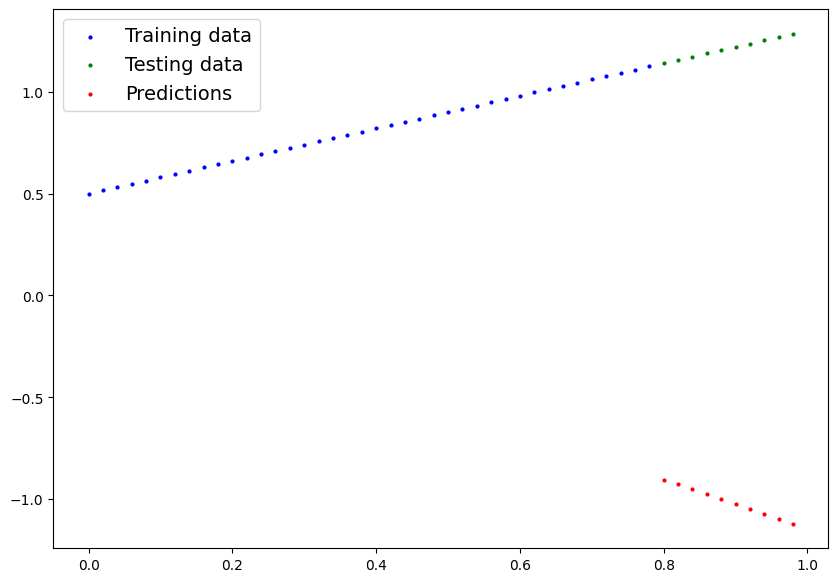

In [18]:
plot_predictions(predictions=y_preds)

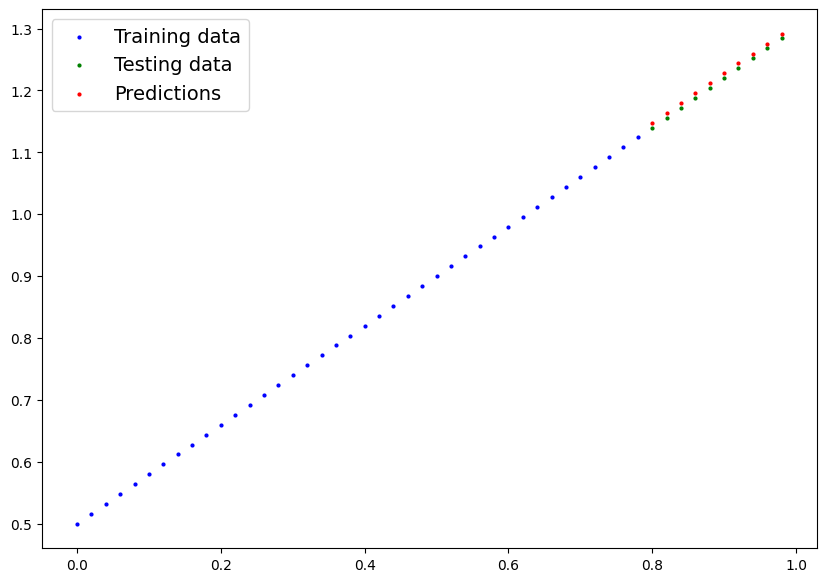

OrderedDict({'weights': tensor([0.7983]), 'bias': tensor([0.5092])})
Parameter containing:
tensor([0.7983], requires_grad=True) Parameter containing:
tensor([0.5092], requires_grad=True)


In [19]:
plot_predictions(predictions=y_preds_new)
print(model_0.state_dict())
print(list(model_0.parameters())[0], list(model_0.parameters())[1])


## Plot the loss curves
### plt.plot accepts only numpy arrays

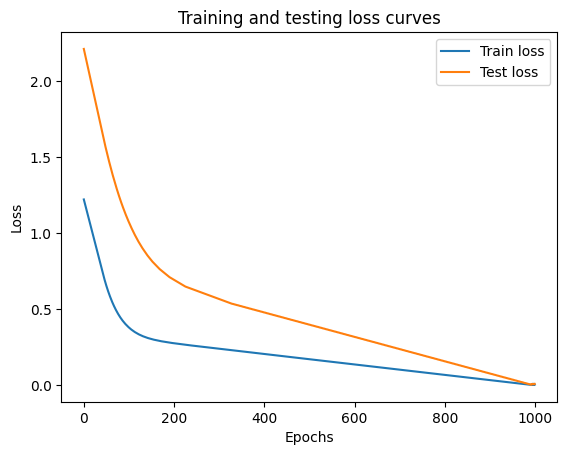

In [20]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train loss'   )
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label='Test loss')
plt.title('Training and testing loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()


# Saving model in Pytorch
`torch.save()` - save Pytorch objects in Python's pickle format

`torch.load()` - allows to load a saved Pytorch object

`torch.nn.Module.load_state_dict()` - load a model's saved state dictionary






In [21]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) 
# parents=True: create parent directories if they don't exist, 
# exist_ok=True: if the directory already exists, don't raise an error

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH) 
# obj: the object to save, 
# f: the file path to save the object to



Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a model in Pytorch



/tmp/ipykernel_53908/2805687165.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


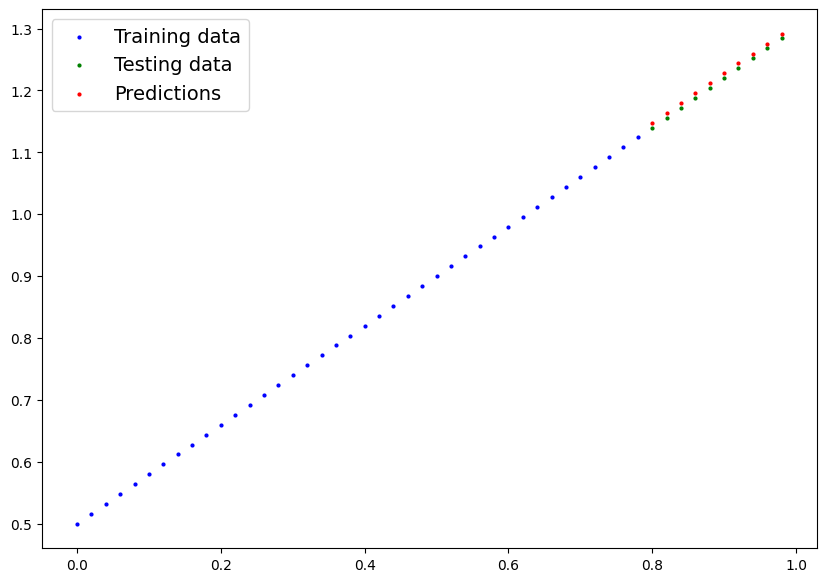

In [22]:

# Loading a model in Pytorch
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

# Making predictions using a loaded model
with torch.inference_mode():
    loaded_model_0.eval()
    loaded_model_preds = loaded_model_0(X_test)

plot_predictions(predictions=loaded_model_preds)


# PUTTING IT ALL TOGETHER

In [23]:
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.__version__

'2.5.1+cu124'

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [25]:
# Create data using linear regression formula
weight = 0.1
bias = 0.2
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
# without unsqueeze, it's a tensor of shape (100,)
y = weight * X + bias
print(X[:10], y[:10])



tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) tensor([[0.2000],
        [0.2020],
        [0.2040],
        [0.2060],
        [0.2080],
        [0.2100],
        [0.2120],
        [0.2140],
        [0.2160],
        [0.2180]])


In [26]:
#split data into training and testing
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

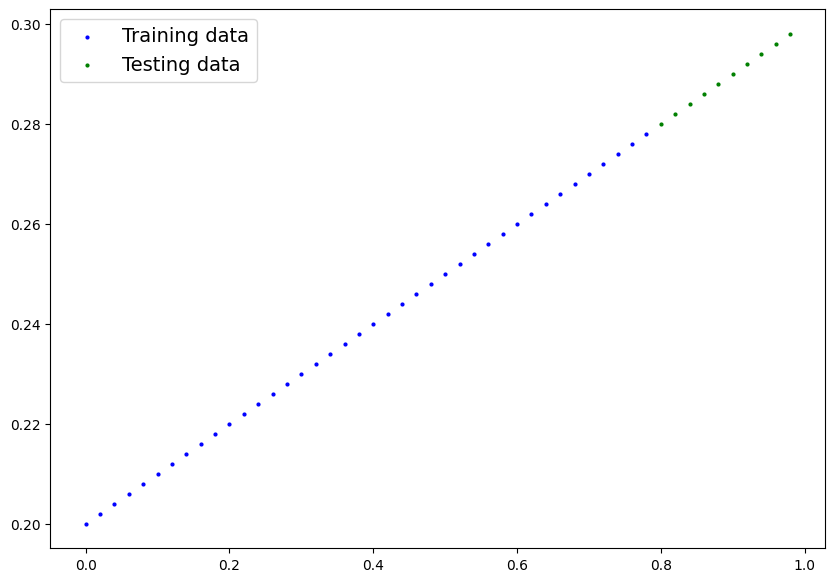

In [27]:
# Plot the data, error matplotlib not charged
plot_predictions(X_train, y_train, X_test, y_test)


In [28]:
from torch import nn

class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, 
                                    out_features=1)
        # input of size 1, output of size 1

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# set the random seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()





(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

## Check the device and switch to GPU if possible




In [29]:
next(model_1.parameters()).device 

device(type='cpu')

In [30]:
model_1.to(device)
next(model_1.parameters()).device 


device(type='cuda', index=0)

## Training
### For training, we need:
* Loss function
* Optimizer
* Training loop
* Testing loop





In [31]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

In [32]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)


### Training loop

In [33]:
torch.manual_seed(42)
epochs = 1000

# Put data on the device data (GPU)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    #1. Forward pass
    y_pred = model_1(X_train)

    #2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    #3. Optimizer zero grad
    optimizer.zero_grad()

    #4. Perform backpropagation
    loss.backward()

    #5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0: 
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")



Epoch: 0 | Loss: 0.8891779184341431 | Test loss: 1.207976222038269
Epoch: 10 | Loss: 0.7739680409431458 | Test loss: 1.0732663869857788
Epoch: 20 | Loss: 0.6587581634521484 | Test loss: 0.9385566115379333
Epoch: 30 | Loss: 0.5435482859611511 | Test loss: 0.8038467764854431
Epoch: 40 | Loss: 0.4283384382724762 | Test loss: 0.6691369414329529
Epoch: 50 | Loss: 0.3131285607814789 | Test loss: 0.5344271063804626
Epoch: 60 | Loss: 0.19791868329048157 | Test loss: 0.39971718192100525
Epoch: 70 | Loss: 0.10804491490125656 | Test loss: 0.28325483202934265
Epoch: 80 | Loss: 0.07703547924757004 | Test loss: 0.21338318288326263
Epoch: 90 | Loss: 0.0670076236128807 | Test loss: 0.17452800273895264
Epoch: 100 | Loss: 0.062281813472509384 | Test loss: 0.15338250994682312
Epoch: 110 | Loss: 0.05861920863389969 | Test loss: 0.140328511595726
Epoch: 120 | Loss: 0.05512920767068863 | Test loss: 0.12930849194526672
Epoch: 130 | Loss: 0.05166677385568619 | Test loss: 0.12034916877746582
Epoch: 140 | Loss:

### Check the state dictionary

In [34]:
model_1.state_dict()


OrderedDict([('linear_layer.weight', tensor([[0.1053]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2005], device='cuda:0'))])

In [35]:
weight, bias

(0.1, 0.2)

### Making and evaluating predictions

In [36]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions
with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds # predictions are on GPU, take care




tensor([[0.2847],
        [0.2868],
        [0.2889],
        [0.2910],
        [0.2932],
        [0.2953],
        [0.2974],
        [0.2995],
        [0.3016],
        [0.3037]], device='cuda:0')

In [37]:
y_preds.shape
print(y_preds)

tensor([[0.2847],
        [0.2868],
        [0.2889],
        [0.2910],
        [0.2932],
        [0.2953],
        [0.2974],
        [0.2995],
        [0.3016],
        [0.3037]], device='cuda:0')


# Check out our model predictions visually

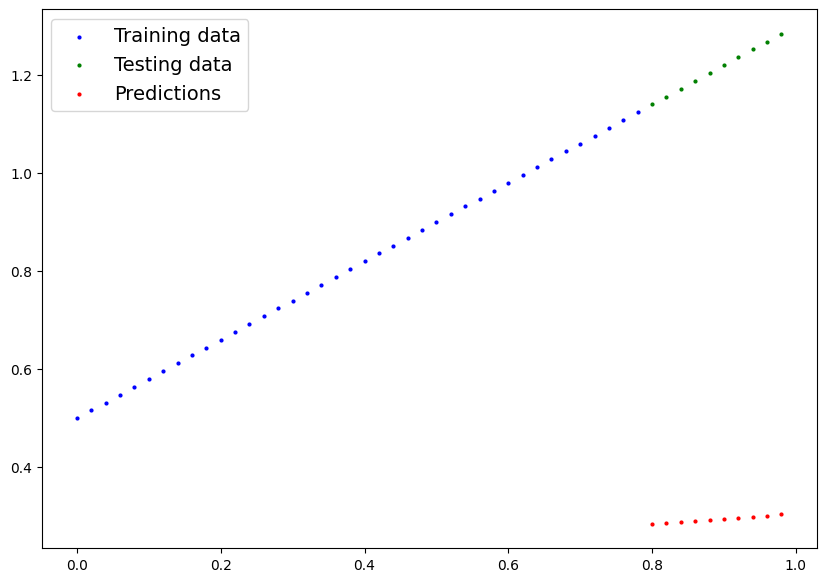

In [38]:
plot_predictions(predictions=y_preds.cpu())


## Savind and loading a trained model

In [39]:
from pathlib import Path
#1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_1.pth


### Loading a saved model




In [40]:
#1. Create a new instance of the linear regression model class
loaded_model_1 = LinearRegressionModelV2()

#2. Load the saved model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

#3. Put the loaded model to device
loaded_model_1.to(device)

/tmp/ipykernel_53908/652694881.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [41]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [42]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.1053]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2005], device='cuda:0'))])

## Evaluate the loaded model

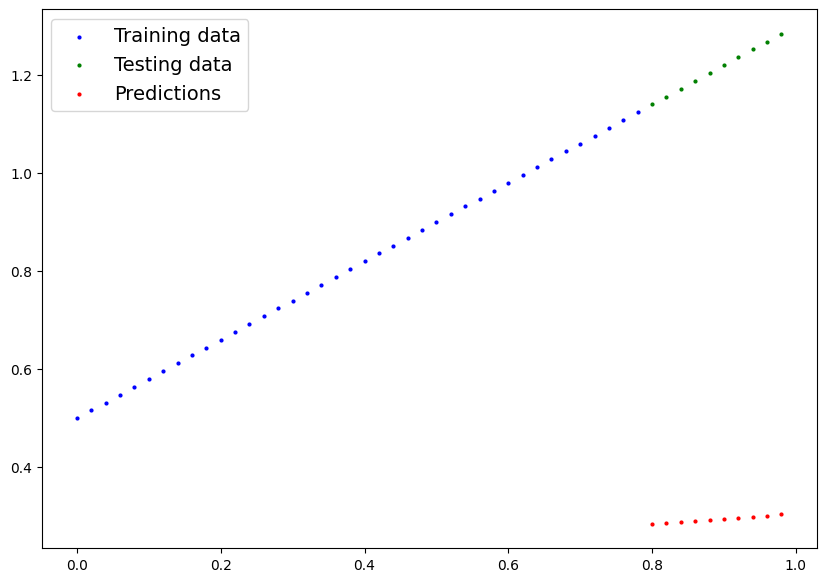

In [43]:
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_1(X_test)

plot_predictions(predictions=loaded_model_preds.cpu())

